In [1]:
import numpy as np
import matplotlib.pyplot as plt 

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

## 1. Project Introduction
### 1.1 Hardware

In [160]:
# check ibmq quantum computer availability
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_manila')
print(backend.status().operational, backend.status().pending_jobs)
# backend
provider.get_backend('ibmq_manila')

True 33


<IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>

## 2. Encoding
### 2.1 Circuit with nearest-neighbour gates

In [3]:
# Define encoding circuit function.
def encoding_5q_code(circ, reg_q, reg_c=()):
    """
    Take a QuantumCircuit() and encode 5-qubit
    error correction code.
    """
    
    # 1
    circ.s(reg_q[0])
    circ.h(reg_q[2])
    circ.h(reg_q[4])

    # 2
    circ.cx(reg_q[2], reg_q[1])
    circ.cx(reg_q[4], reg_q[3])
    
    # 3
    circ.h(reg_q[1])
    circ.cx(reg_q[2], reg_q[3])
    circ.s(reg_q[4])
    
    # 4
    circ.s(reg_q[2])
    circ.sdg(reg_q[3])
    circ.swap(reg_q[2],reg_q[3])
    
    # 5
    circ.cx(reg_q[1], reg_q[0])
    circ.s(reg_q[0])
    circ.s(reg_q[1])

    # 6 
    circ.swap(reg_q[1],reg_q[2])
    
    # 7
    circ.cx(reg_q[1], reg_q[0])
    
    # 8
    circ.h(reg_q[1])
    
    # 9
    circ.cx(reg_q[1], reg_q[2])
    
    return circ

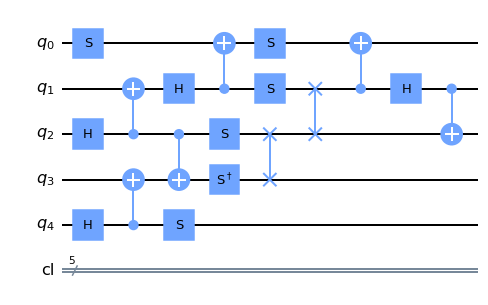

In [4]:
# Encoding circuit diagram
from qiskit import QuantumRegister, ClassicalRegister
import qiskit.quantum_info as qqi

reg_q = QuantumRegister(5,'q')
reg_c = ClassicalRegister(5,'cl')
a,b = 1, 0 #1./np.sqrt(2),1./np.sqrt(2)

circ = QuantumCircuit(reg_q,reg_c)
encoding_5q_code(circ, reg_q)
circ.draw('mpl')
# fig = circ.draw('mpl')
# fig.savefig('encoding_circuit.png',dpi=300,bbox_inches='tight')

### [[5,1,3]] stabilizer group and code space

In [5]:
# 5-qubit stabilizer group with relabeled order
g0 = qqi.Operator(qqi.Pauli('IIIII'))
g1 = qqi.Operator(qqi.Pauli('XIZXZ'))
g2 = qqi.Operator(qqi.Pauli('IXXZZ'))
g3 = qqi.Operator(qqi.Pauli('XZIZX'))
g4 = qqi.Operator(qqi.Pauli('ZZXXI'))

logical_Z = qqi.Operator(qqi.Pauli('ZZZZZ'))
logical_X = qqi.Operator(qqi.Pauli('XXXXX'))
logical_Y = qqi.Operator(qqi.Pauli('YYYYY'))

# a,b = 1,0
g5 = (a*np.conj(a)-b*np.conj(b))*logical_Z + \
    (np.conj(a)*b+np.conj(b)*a)*logical_X + \
    -1j*(np.conj(a)*b-np.conj(b)*a)*logical_Y

g_list = [g1,g2,g3,g4]
g_list5 = [g1,g2,g3,g4,g5]

# array_to_latex(g5.data,max_size=2**5)

### 2.2 Calculation of logical states
#### classical simulation

In [6]:
# Logical qubit |0_L> and |1_L>, a|0_L>+b|1_L>
logical0 = qqi.Statevector.from_int(0, 2**5)
logical1 = qqi.Statevector.from_int(1, 2**5)
logical_ab = a*logical0+b*logical1
logical0 = logical0.evolve(circ)
logical1 = logical1.evolve(circ)
logical_ab = logical_ab.evolve(circ)
# logical0_data = np.array([1/4,...])

# logical0.dat
# array_to_latex(logical0.data,max_size=2**5)
logical0.draw('latex')

<IPython.core.display.Latex object>

In [7]:
# Display logical state in latex because qiskit Statevector.draw('latex') method can't display so many terms.
state_view = []
# data_view = []
# Split a 16-term logical state into 4*4 states to display.
for i in range(4):
    data_ori = np.zeros(2**5,dtype=np.cdouble)
    sl = slice(i*2**3,(i+1)*2**3)
    data_ori[sl] = logical0.data[sl]
    # data_view.append(data_ori)
    state_view.append(qqi.Statevector(data=data_ori))
    
latex_str = ''
for view in state_view:
    latex_str += view.draw('latex').data
jpt_display = state_view[0].draw('latex')
jpt_display.data = latex_str
jpt_display

<IPython.core.display.Latex object>

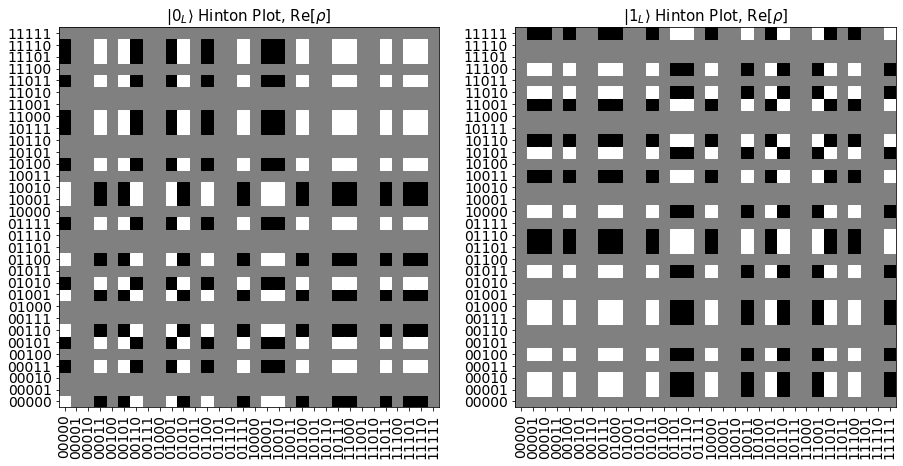

In [8]:
# visualize |0_L>, |1_L> (Hinton plot)
# white block \rho_ij > 0, black block \rho_ij < 0
from qiskit.visualization import plot_state_city, plot_state_hinton, plot_bloch_multivector

fig, ax = plt.subplots(1,2,figsize=(15,8))
fig.patch.set_facecolor('white')
plot_state_hinton(logical0,ax_real=ax[0])
plot_state_hinton(logical1,ax_real=ax[1])
ax[0].set_title(r"$\left|0_L\right\rangle$ Hinton Plot, Re[$\rho$]",fontsize=15)
ax[1].set_title(r"$\left|1_L\right\rangle$ Hinton Plot, Re[$\rho$]",fontsize=15)
plt.show()
# fig.savefig('logical_hinton.png',dpi=300,bbox_inches='tight')

#### on quantum computer

id: 872a6d2f342f4842a24774cc40c14db7-16394550880382867


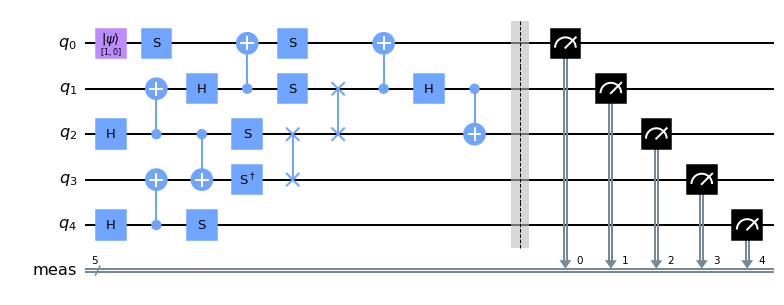

In [9]:
# encode and visualize |0_L> and |+_L>
from qiskit.providers.ibmq.managed import IBMQJobManager

coeff_0 = [1., 0.]  # |0_L>
coeff_plus = [1./np.sqrt(2), 1./np.sqrt(2)]  # |+_L>

circ_0 = QuantumCircuit(reg_q)
circ_plus = QuantumCircuit(reg_q)
circ_0.initialize(params=coeff_0,qubits=0)
circ_plus.initialize(params=coeff_plus,qubits=0)
encoding_5q_code(circ_0, reg_q)
encoding_5q_code(circ_plus, reg_q)
circ_0.measure_all()
circ_plus.measure_all()
circ_list = [circ_0,circ_plus]

run_or_not = False
if run_or_not:
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibmq_manila')
    circ_complie = transpile(circ_list, backend=backend)
    job_manager = IBMQJobManager()
    job_set = job_manager.run(circ_complie, backend=backend, shots=1024)
else:
    job_set_id = '872a6d2f342f4842a24774cc40c14db7-16394550880382867'
    job_manager = IBMQJobManager()
    job_set = job_manager.retrieve_job_set(job_set_id,provider)

print('id: {}'.format(job_set_id))
circ_0.draw('mpl')

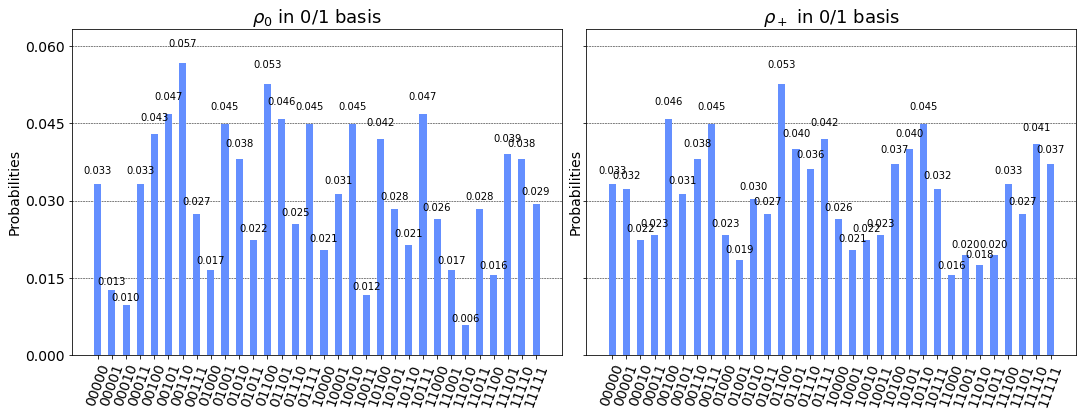

In [10]:
# visualizations
from qiskit.visualization import plot_histogram

fig, ax = plt.subplots(1,2,sharey=True,figsize=(18,6),gridspec_kw ={'wspace':0.05})
fig.patch.set_facecolor('white')
counts_0 = job_set.results().get_counts(0)
counts_plus = job_set.results().get_counts(1)

plot_histogram(counts_0,ax=ax[0])
plot_histogram(counts_plus,ax=ax[1])
ax[0].set_title(r'$\rho_0$ in 0/1 basis',fontsize=18)
ax[1].set_title(r'$\rho_+$ in 0/1 basis',fontsize=18)
ax[0].grid(axis='y',color='k',ls='--',lw=0.5)
ax[1].grid(axis='y',color='k',ls='--',lw=0.5)
plt.show()
# fig.savefig('logical_histogram.png',dpi=300,bbox_inches='tight')

## 3. Verification of error syndrome
### 3.1 Ideal error syndromes

In [11]:
# syndrome table shape = (qubit, error, stabilizer)
# Note there is no qiskit rule qubit ordering problem.
syndrome_table = np.array([
    [[1,1,1,-1],[-1,1,-1,-1],[-1,1,-1,1]],
    [[1,1,-1,-1],[1,-1,-1,-1],[1,-1,1,1]],
    [[-1,1,1,1],[-1,-1,1,-1],[1,-1,1,-1]],
    [[1,-1,-1,1],[-1,-1,-1,-1],[-1,1,1,-1]],
    [[-1,-1,1,1],[-1,-1,-1,1],[1,1,-1,1]]
])
print(syndrome_table.shape)

(5, 3, 4)


### 3.2 Actual error syndromes verification

In [12]:
# string for stabilizer operator [g1 ,g2, g3, g4]
str_g = ['xizxz','ixxzz','xzizx','zzxxi']
 
def tomo_gi_transform(circ,str_gi):
    """
    Apply tomographyical transformations according to g.
    
    Parameters
    ----------
    circ : qiskit.QuantumCircuit()
        circ to operate
    str_gi : string
        string of stabilizer
    """
    for i_qubit, tomo_gate in enumerate(str_gi):
        # 'i': nothing; 'x': apply H; 'y': apply SH; 'z': nothing
        if tomo_gate == 'x':
            circ.h(i_qubit)
        elif tomo_gate == 'y':
            circ.h(i_qubit)
            circ.s(i_qubit)  # phase gate diag(1, i)
    return circ

In [13]:
def syndrome_verification_circ(coeff):
    """
    Create sydrome verification circuits with intentionally injected error 
    and tomographically apply transformations according to g.
    
    Parameters
    ----------
    coeff : array_like, shape (2, )
        coefficient [a, b] for logical state. |\psi>=a|0_L>+b|1_L>
    """
    circ_error = []
    errorname = ['x','y','z']

    for i_qubit in range(5):
        circ_temp = []
        for r_error in errorname:
            circ_r = []
            for str_gi in str_g:
                # create a new circ_s_c with r_error gate on i_qubit, then
                # generate expectation of stabilizer gi by tomography

                # 1. initialize new circuit
                reg_q_temp = QuantumRegister(5,'q')
                circ_r_s = QuantumCircuit(reg_q_temp)
                circ_r_s.initialize(params=coeff,qubits=0)
                # 2. encoding
                encoding_5q_code(circ_r_s,reg_q_temp)
                # 3. inject error
                circ_r_s.barrier()
                getattr(circ_r_s,r_error)(i_qubit)
                # 4. apply tomographyical transformation
                circ_r_s.barrier()
                tomo_gi_transform(circ_r_s,str_gi)
                # 5. measure all qubits in |0>, |1>
                circ_r_s.measure_all()

                circ_r.append(circ_r_s)
            circ_temp += circ_r
        circ_error += circ_temp
    return circ_error

In [103]:
# run syndrome verification circuits on ibmq
def run_circuits(circ_list,qc_name,shots,task_name):
    """
    Run a list of circuits on ibmq quantum computer and 
    output job_set_id and job_set.
    
    Parameters
    ----------
    circ_list : array_like, shape (n, )
        list of qiskit.QuantumCircuit() to run
    qc_name : string
        name of backend
    shots : int
        Number of repetitions of each circuit, for sampling.
    task_name : string
        job_set name
    """
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend(qc_name)
    circ_complie = transpile(circ_list, backend=backend)
    job_manager = IBMQJobManager()
    job_set = job_manager.run(circ_complie, backend=backend, shots=shots, name=task_name)

    job_set_id = job_set.job_set_id()
    # job_set = job_manager.retrieve_job_set(job_set_id=job_set_id)

    # jobs = job_set.jobs()
    # results = job_set.results()
    
    return job_set_id, job_set 

60


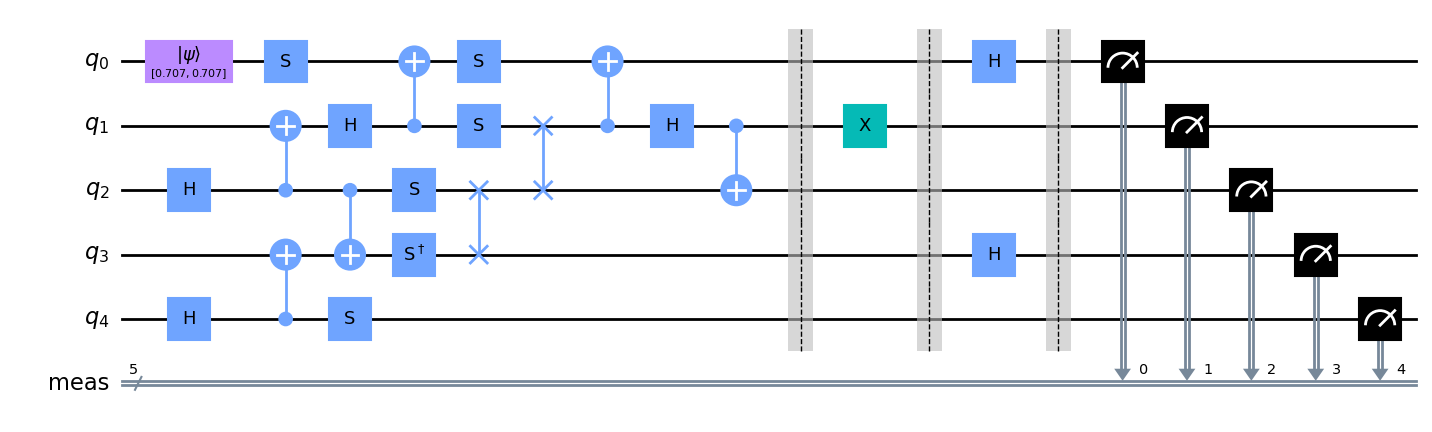

In [159]:
# generate circuit lists
coeff_0 = [1., 0.]  # |0_L>
coeff_plus = [1./np.sqrt(2), 1./np.sqrt(2)]  # |+_L>

circ_error_0 = syndrome_verification_circ(coeff_0)
circ_error_plus = syndrome_verification_circ(coeff_plus)

# check and visualize created circuits
print(len(circ_error_0))
circ_error_plus[12].draw()
# fig = circ_error_plus[12].draw('mpl')
# fig.savefig('plus_2X_circuit.png',dpi=300,bbox_inches='tight')

In [16]:
# run syndrome verification for |0_L> and |+_L>
run_or_not = False
qc = 'ibmq_manila'
n_shot = 1024
if run_or_not:
    job_set_id_syn_0, job_set_syn_0 = run_circuits(circ_error_0,qc_name=qc,shots=n_shot,task_name='syndrome_0')
    job_set_id_syn_plus, job_set_syn_plus = run_circuits(circ_error_plus,qc_name=qc,shots=n_shot,task_name='syndrome_plus')
else:
    job_set_id_syn_0 = '200f71978bc541578b77b3fec461cf6c-16393620386375632'
    # shots=1024 job: '200f71978bc541578b77b3fec461cf6c-16393620386375632'
    # shots=2**14 job: '11b34651c7d34209853d2795c8b3d5a1-16394988120550692'
    job_set_id_syn_plus = 'd4c5eb1319a04dccb0e8a47c714a59c6-16393620409830256'
    # shots=1024 job: 'd4c5eb1319a04dccb0e8a47c714a59c6-16393620409830256'
    # shots=2**14 job: 'dc9e95d650fd4dfc80448f3c1ed51a60-16394988154732933'
    job_manager = IBMQJobManager()
    job_set_syn_0 = job_manager.retrieve_job_set(job_set_id_syn_0,provider)
    job_set_syn_plus = job_manager.retrieve_job_set(job_set_id_syn_plus,provider)
    
print('|0_L>: {}'.format(job_set_id_syn_0))
print('|+_L>: {}'.format(job_set_id_syn_plus))

# job_set = job_manager.retrieve_job_set(job_set_id=job_set_id)

|0_L>: 200f71978bc541578b77b3fec461cf6c-16393620386375632
|+_L>: d4c5eb1319a04dccb0e8a47c714a59c6-16393620409830256


#### data processing: counts to Stokes parameters

In [156]:
# reshape counts in job_set
def counts_reshape(job_set):
    # counts_all = nd.array(job_set.results().get_counts())
    # counts_all = counts_all.reshape(5,3)
    results = job_set.results()
    counts_all = []
    for i_qubit in range(5):
        counts_i_qubit = []
        for j_error in range(3):
            count_j_error = []
            for k_stabilizer in range(4):
                c_index = i_qubit*3*4 + j_error*4 + k_stabilizer
                count_j_error.append(results.get_counts(c_index))
            counts_i_qubit.append(count_j_error)
        counts_all.append(counts_i_qubit)
    return np.array(counts_all)

# find the row of desired g in expectation values
def g_row(str_g):
    g_row_list = []
    for str_gi in str_g:
        row = 0
        # print(str_gi[::-1])
        for ith, i_char in enumerate(str_gi):
            if i_char != 'i':
                row += 2**ith
        g_row_list.append(row)
    return g_row_list

# generate the transformation matrix T
def transform_T5():
    matrix_T1 = np.array([[1,1],[1,-1]])
    matrix_T5 = matrix_T1
    for i in range(5-1):
        matrix_T5 = np.kron(matrix_T5,matrix_T1)
    return matrix_T5

# generate basis state in string (e.g., '00110') in corresponding order
basis_list = []
for ith in range(2**5):
    basis_list.append(str(format(ith+2**5,'b'))[1:])
basis_list = np.array(basis_list)
    
# matrix multiply of transform T and counts
def T5_counts(T5_row,counts_gi):
    counts_col = []
    for basis in basis_list:
        if basis in counts_gi:
            counts_col.append(counts_gi[basis])
        else:
            counts_col.append(0)
    counts_col = np.array(counts_col)
    exp_value = np.dot(T5_row,counts_col)
    return exp_value

# generate all expectation value for gi from all counts
def stabilizer_expectation(counts_all,matrix_T5,g_row_list,n_shot):
    expectation = []
    for i_qubit in range(5):
        exp_i_qubit = []
        for j_error in range(3):
            exp_j_error = []
            for k_stabilizer in range(4):
                prob_ijk = T5_counts(matrix_T5[g_row_list[k_stabilizer]],counts_all[i_qubit,j_error,k_stabilizer])/n_shot
                exp_j_error.append(prob_ijk)
            exp_i_qubit.append(exp_j_error)
        expectation.append(exp_i_qubit)
    return np.array(expectation)

# standard deviation for gi from all counts
def stabilizer_std(counts_all,matrix_T5,g_row_list,n_shot):
    std = np.sqrt(1-stabilizer_expectation(counts_all,matrix_T5,g_row_list,n_shot)**2)
    return np.array(std)

In [157]:
# |0_L> stabilizer expectations
counts_all_syn_0 = counts_reshape(job_set_syn_0)
g_row_list = g_row(str_g)
matrix_T5 = transform_T5()
# basis_list
expectation_syn_0 = stabilizer_expectation(counts_all_syn_0,matrix_T5,g_row_list,n_shot)
std_syn_0 = stabilizer_std(counts_all_syn_0,matrix_T5,g_row_list,n_shot)
expectation_syn_0, std_syn_0

(array([[[ 0.0703125 ,  0.4453125 ,  0.45117188, -0.0546875 ],
         [-0.12109375,  0.44921875, -0.40820312, -0.09179688],
         [-0.12109375,  0.45898438, -0.40820312,  0.14257812]],
 
        [[ 0.13085938,  0.421875  , -0.42773438, -0.08398438],
         [ 0.1015625 , -0.41210938, -0.40820312, -0.11914062],
         [ 0.140625  , -0.4453125 ,  0.43945312,  0.13671875]],
 
        [[-0.16015625,  0.37695312,  0.45117188,  0.11132812],
         [-0.1484375 , -0.43359375,  0.41601562, -0.140625  ],
         [ 0.09960938, -0.45117188,  0.46484375, -0.140625  ]],
 
        [[ 0.15234375, -0.43359375, -0.4453125 ,  0.15234375],
         [-0.11523438, -0.47460938, -0.39453125, -0.1328125 ],
         [-0.13671875,  0.44921875,  0.4453125 , -0.16796875]],
 
        [[-0.14453125, -0.42578125,  0.4140625 ,  0.11328125],
         [-0.13671875, -0.46484375, -0.4375    ,  0.09570312],
         [ 0.13085938,  0.44921875, -0.43554688,  0.09570312]]]),
 array([[[0.99752501, 0.89537522, 0.8924

In [158]:
# |+_L> stabilizer expectations
counts_all_syn_plus = counts_reshape(job_set_syn_plus)
g_row_list = g_row(str_g)
matrix_T5 = transform_T5()
# basis_list
expectation_syn_plus = stabilizer_expectation(counts_all_syn_plus,matrix_T5,g_row_list,n_shot)
std_syn_plus = stabilizer_std(counts_all_syn_plus,matrix_T5,g_row_list,n_shot)
expectation_syn_plus, std_syn_plus

(array([[[ 0.12890625,  0.4140625 ,  0.34179688, -0.04101562],
         [-0.19140625,  0.42578125, -0.33203125, -0.14257812],
         [-0.11328125,  0.3984375 , -0.36523438,  0.16015625]],
 
        [[ 0.15039062,  0.39257812, -0.3671875 , -0.078125  ],
         [ 0.12890625, -0.35742188, -0.31835938, -0.08203125],
         [ 0.15820312, -0.38867188,  0.36523438,  0.05859375]],
 
        [[-0.07226562,  0.34765625,  0.37695312,  0.13476562],
         [-0.14453125, -0.43164062,  0.3046875 , -0.12304688],
         [ 0.09570312, -0.4375    ,  0.36132812, -0.13671875]],
 
        [[ 0.13671875, -0.37890625, -0.34765625,  0.09179688],
         [-0.15234375, -0.46679688, -0.39648438, -0.13085938],
         [-0.0546875 ,  0.3671875 ,  0.34570312, -0.1875    ]],
 
        [[-0.09179688, -0.3203125 ,  0.30664062,  0.12109375],
         [-0.07226562, -0.453125  , -0.28710938,  0.11132812],
         [ 0.15234375,  0.42773438, -0.39453125,  0.10351562]]]),
 array([[[0.99165678, 0.91024845, 0.9397

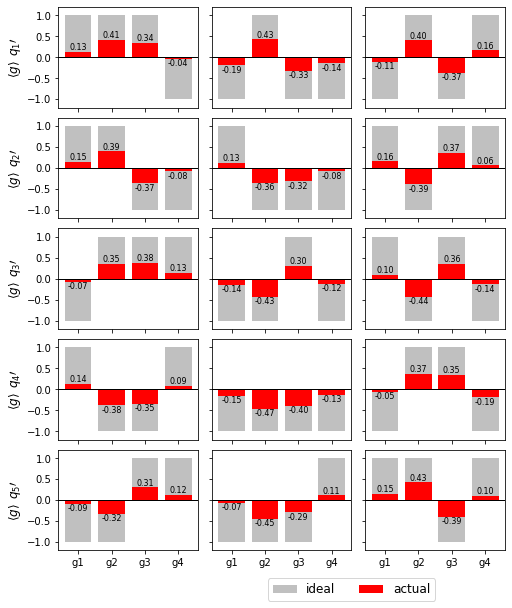

In [20]:
# syndrome plots
g_x = np.arange(4)
g_label = ['g1','g2','g3','g4']
font_size = 12
# plt.style.use('classic')
fig, ax = plt.subplots(5,3,figsize=(8,10),gridspec_kw ={'wspace':0.1,'hspace':0.1})
fig.patch.set_facecolor('white')
for row in range(5):
    for col in range(3):
        p1 = ax[row,col].bar(g_label,syndrome_table[row,col],color='silver',label='ideal')
        p2 = ax[row,col].bar(g_label,expectation_syn_plus[row,col],color='r',label='actual')
        # p2 = ax[row,col].bar(g_label,expectation_syn_plus[row,col],yerr=std_syn_plus[row,col],
        #                      color='r',error_kw={'elinewidth':1,'ecolor':'k'},label='actual')
        ax[row,col].bar_label(p2,fmt='%0.2f',label_type='edge',fontsize=8)
        ax[row,col].set_ylim(-1.2,1.2)
        ax[row,col].axhline(y=0.,color='k',ls='-',lw=1)
        if row < 4:
            ax[row,col].set_xticklabels([])
        elif row == 0:
            ax[row,col].title.set_text('{}-error'.format(['X','Y','Z'][col]))
            ax[row,col].set_xticklabels(g_label,fontsize=font_size)
        if col > 0:
            ax[row,col].set_yticklabels([])
        elif col == 0:
            ax[row,col].set_ylabel(r'$\langle g \rangle\:\: q_{{{}}}\prime$'.format(row+1),fontsize=font_size)
ax[4,2].legend(ncol=2,loc=(-0.7,-0.5),fontsize=font_size)
plt.show()
# fig.savefig('syndrome_histogram_plus_std.png',dpi=300,bbox_inches='tight')

## 4. Fidelity
### 4.1 Fidelity of encoding logical qubit states

In [146]:
from itertools import combinations

# string for stabilizer operator [g1 ,g2, g3, g4]
str_g = ['xizxz','ixxzz','xzizx','zzxxi']

# generate sting of product of stabilizer
def product_g_str(str_g):
    pauli_rule = {}
    for key in ['ii','xx','yy','zz']:
        pauli_rule[key] = 'i'
    for key in ['ix','xi','yz','zy']:
        pauli_rule[key] = 'x'
    for key in ['iy','yi','xz','zx']:
        pauli_rule[key] = 'y'
    for key in ['iz','zi','xy','yx']:
        pauli_rule[key] = 'z'
        
    n = len(str_g)
    
    def product_op(*arg):
        ops = arg
        n = len(ops)
        A = ops[0]
        for i in range(1,n):
            B = ops[i]
            C = ''
            for a,b in zip(A,B):
                c = a+b
                C += pauli_rule[c]
            A = C
        return A
    
    # def check_same(array):
    #     mark = False
    #     for i in range(len(array)-1):
    #         if array[i] in array[i+1:]:
    #             mark = True
    #             break
    #     return mark
                
    str_g_prod = []
    for i_prod in range(1,n+1):
        str_i_prod = []
        for ops in combinations(str_g,i_prod):
            prod_result = product_op(*ops)
            str_i_prod.append(prod_result)
        str_g_prod.extend(str_i_prod)
    return str_g_prod

str_g_prod = product_g_str(str_g)
print(str_g_prod)

['xizxz', 'ixxzz', 'xzizx', 'zzxxi', 'xxyyi', 'izzyy', 'yzyiz', 'xyxiy', 'zyiyz', 'yixyx', 'iyyxx', 'yyzzi', 'ziyzy', 'yxixy', 'zxzix']


In [147]:
def fidelity_projector_circ(coeff,str_g_prod):
    """
    
    Parameters
    ----------
    coeff : array_like, shape (2, )
        coefficient [a, b] for logical state. |\psi>=a|0_L>+b|1_L>
    """
    circ_proj = []

    for str_gi in str_g_prod:
        # 1. initialize new circuit
        reg_q_temp = QuantumRegister(5,'q')
        circ_r_s = QuantumCircuit(reg_q_temp)
        circ_r_s.initialize(params=coeff,qubits=0)
        # 2. encoding
        encoding_5q_code(circ_r_s,reg_q_temp)
        # 3. apply tomographyical transformation
        circ_r_s.barrier()
        tomo_gi_transform(circ_r_s,str_gi)
        # 4. measure all qubits in |0>, |1>
        circ_r_s.measure_all()

        circ_proj.append(circ_r_s)
    return circ_proj

['xizxz', 'ixxzz', 'xzizx', 'zzxxi', 'xxyyi', 'izzyy', 'yzyiz', 'xyxiy', 'zyiyz', 'yixyx', 'iyyxx', 'yyzzi', 'ziyzy', 'yxixy', 'zxzix']
15


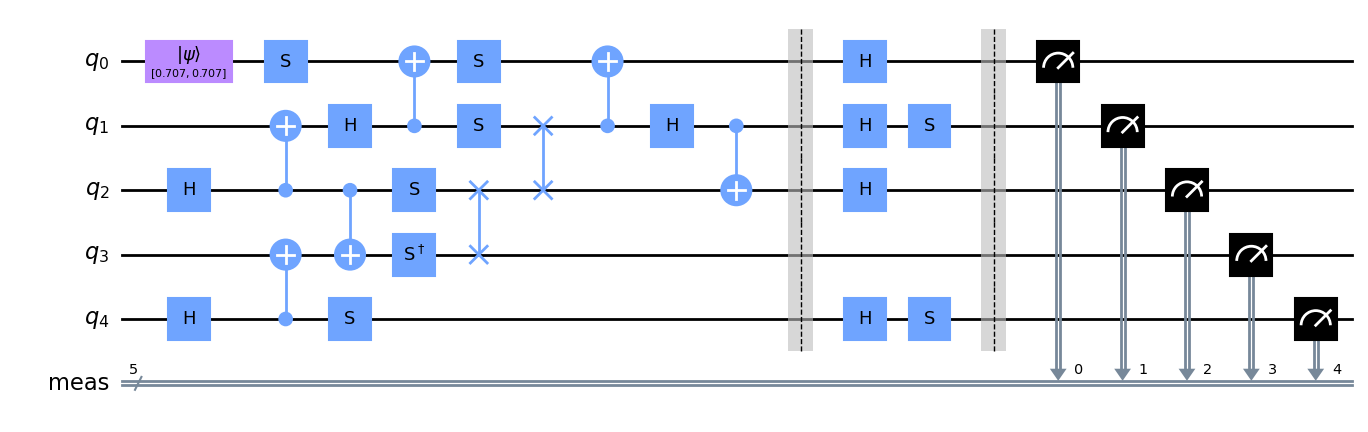

In [155]:
# generate circuit lists
coeff_0 = [1., 0.]  # |0_L>
coeff_plus = [1./np.sqrt(2), 1./np.sqrt(2)]  # |+_L>

str_g_prod = product_g_str(str_g)
print(str_g_prod)

circ_fid_0 = fidelity_projector_circ(coeff_0,str_g_prod)
circ_fid_plus = fidelity_projector_circ(coeff_plus,str_g_prod)

# check and visualize created circuits
print(len(circ_fid_0))
circ_fid_plus[7].draw()
# fig = circ_fid_plus[7].draw('mpl')
# fig.savefig('plus_xyxiy_circuit.png',dpi=300,bbox_inches='tight')

In [118]:
# run fidelity calculation for |0_L> and |+_L>
run_or_not = False
qc = 'ibmq_manila'
n_shot = 1024
if run_or_not:
    job_set_id_fid_0, job_set_fid_0 = run_circuits(circ_fid_0,qc_name=qc,shots=n_shot,task_name='fidelity_0')
    job_set_id_fid_plus, job_set_fid_plus = run_circuits(circ_fid_plus,qc_name=qc,shots=n_shot,task_name='fidelity_plus')
else:
    job_set_id_fid_0 = '74f9a0c8b09a4931b027bdce4e311a81-16395571497507873'
    job_set_id_fid_plus = '3c067af0c5b348e39583bae99078b55e-16395571518398485'
    job_manager = IBMQJobManager()
    job_set_fid_0 = job_manager.retrieve_job_set(job_set_id_fid_0,provider)
    job_set_fid_plus = job_manager.retrieve_job_set(job_set_id_fid_plus,provider)
    
print('|0_L>: {}'.format(job_set_id_fid_0))
print('|+_L>: {}'.format(job_set_id_fid_plus))

# job_set = job_manager.retrieve_job_set(job_set_id=job_set_id)

|0_L>: 74f9a0c8b09a4931b027bdce4e311a81-16395571497507873
|+_L>: 3c067af0c5b348e39583bae99078b55e-16395571518398485


#### data processing: counts to Stokes parameters

In [145]:
# reshape counts in job_set
def counts_fidelity(job_set):
    results = job_set.results()
    counts_all = []
    for stabilizer in range(len(str_g_prod)):
        counts_all.append(results.get_counts(stabilizer))
    return np.array(counts_all)

# generate all expectation value for gi from all counts
def stabilizer_expectation_fidelity(counts_all,matrix_T5,g_row_list,n_shot):
    expectation = []
    for stabilizer in range(len(str_g_prod)):
        prob_ijk = T5_counts(matrix_T5[g_row_list[stabilizer]],counts_all[stabilizer])/n_shot
        expectation.append(prob_ijk)
    return np.array(expectation)

In [149]:
# |0_L> stabilizer expectations
counts_all_fid_0 = counts_fidelity(job_set_fid_0)
g_row_list = g_row(str_g_prod)
matrix_T5 = transform_T5()
expectation_fid_0 = stabilizer_expectation_fidelity(counts_all_fid_0,matrix_T5,g_row_list,n_shot)
fidelity_0 = 1/2**4*(1+np.sum(expectation_fid_0))
print('fidelity for |0_L>: {}'.format(fidelity_0))
expectation_fid_0

fidelity for |0_L>: 0.0670166015625


array([ 0.01367188,  0.        ,  0.01171875, -0.0546875 ,  0.05664062,
       -0.07226562,  0.0234375 , -0.01367188,  0.02148438,  0.08398438,
       -0.03125   , -0.01953125,  0.05859375, -0.06835938,  0.0625    ])

In [142]:
# |+_L> stabilizer expectations
counts_all_fid_plus = counts_fidelity(job_set_fid_plus)
g_row_list = g_row(str_g_prod)
matrix_T5 = transform_T5()
expectation_fid_plus = stabilizer_expectation_fidelity(counts_all_fid_plus,matrix_T5,g_row_list,n_shot)
fidelity_plus = 1/2**4*(1+np.sum(expectation_fid_plus))
print('fidelity for |+_L>: {}'.format(fidelity_plus))
expectation_fid_plus

fidelity for |+_L>: 0.0684814453125


array([ 0.01757812, -0.10742188,  0.02148438, -0.0078125 ,  0.        ,
        0.03515625,  0.04296875,  0.01171875,  0.00390625,  0.00195312,
        0.0546875 ,  0.        ,  0.03515625, -0.0078125 , -0.00585938])

In [143]:
##### %matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)